In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from stochastic_dynamics.models import DeepLagEmbed
from stochastic_dynamics.generators import tvar
from stochastic_dynamics.utils import train_loop, bench_loop
from stochastic_dynamics.plottings import plot_history, plot_coefficients_by_p, plot_tvar_sample

from torchinfo import summary

In [2]:
from sklearn.model_selection import train_test_split

def load_dataset_npz(path):
    d = np.load(path, allow_pickle=True)
    return {
        "X": d["X"],
        "A": d["A"],
        "p_true": d["p_true"],
        "class_id": d["class_id"],
        "class_names": d["class_names"],
        "noise_std": d["noise_std"],
        "meta": list(d["meta"]),
    }

def pinn_processor(npz_path, family='', p_min=1, train_split=0.8, random_state=42):
    """
    Load a saved TVAR benchmark dataset and return stratified train/val arrays.
    
    Args
    ----
    npz_path : str
        Path to the .npz file saved by save_dataset_npz().
    family : str
        The class/family name to filter by.
    p_min : int
        Minimum AR order used when generating the dataset. 
        Used to compute 0-indexed class labels for cross entropy.
    train_split : float
        Fraction of data to use for training (default 0.8 for 80/20 split).
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    X_train, X_val : arrays, shape [N_train, T], [N_val, T]
        Time series samples for train and validation.
    coeffs_train, coeffs_val : arrays, shape [N_train, T, p_max], [N_val, T, p_max]
        Time-varying AR coefficients for train and validation.
    p_train, p_val : arrays, shape [N_train], [N_val]
        True AR order for each sample, 0-indexed for cross entropy.
    """
    dataset = load_dataset_npz(npz_path)

    datasets_by_class = {}
    for i, classname in enumerate(dataset["class_names"]):
        mask = dataset["class_id"] == i
        datasets_by_class[classname] = {
            "X": dataset["X"][mask],
            "A": dataset["A"][mask],
            "p_true": dataset["p_true"][mask],
            "class_id": dataset["class_id"][mask],
            "class_names": dataset["class_names"],
            "noise_std": dataset["noise_std"][mask] if dataset["noise_std"].ndim > 0 else dataset["noise_std"],
            "meta": [dataset["meta"][j] for j in np.where(mask)[0]],
        }
    
    subdata = datasets_by_class[family]
    
    X = subdata["X"]              # [N, T]
    coeffs = subdata["A"]         # [N, T, p_max]
    p_true_raw = subdata["p_true"]  # [N], actual AR orders (e.g., 1, 2, 4, 6)
    
    # Convert p_true to 0-indexed labels for cross entropy loss
    unique_p = np.sort(np.unique(p_true_raw))
    p_to_idx = {int(p): i for i, p in enumerate(unique_p)}
    p_true = np.array([p_to_idx[int(p)] for p in p_true_raw], dtype=np.int64)
    
    # Stratified train/val split to maintain balanced p distribution
    indices = np.arange(len(X))
    train_idx, val_idx = train_test_split(
        indices, 
        train_size=train_split, 
        stratify=p_true,  # Ensures balanced p values in both splits
        random_state=random_state
    )
    
    X_train, X_val = X[train_idx], X[val_idx]
    coeffs_train, coeffs_val = coeffs[train_idx], coeffs[val_idx]
    p_train, p_val = p_true[train_idx], p_true[val_idx]
    
    # Print distribution info
    print(f"Total samples: {len(X)} | Train: {len(X_train)} | Val: {len(X_val)}")
    print(f"Train p distribution: {dict(zip(*np.unique(p_train, return_counts=True)))}")
    print(f"Val p distribution:   {dict(zip(*np.unique(p_val, return_counts=True)))}")
    
    return X_train, coeffs_train, p_train, X_val, coeffs_val, p_val


In [3]:
data = "/Users/novak/Documents/UTSW/erfan/StocasticDiffEq_Simulation/ref/novak_data.npz"
X_train, coef_train, p_train, X_val, coef_val, p_val = pinn_processor(data, family='fourier')

Total samples: 10000 | Train: 8000 | Val: 2000
Train p distribution: {np.int64(0): np.int64(1600), np.int64(1): np.int64(1600), np.int64(2): np.int64(1600), np.int64(3): np.int64(1600), np.int64(4): np.int64(1600)}
Val p distribution:   {np.int64(0): np.int64(400), np.int64(1): np.int64(400), np.int64(2): np.int64(400), np.int64(3): np.int64(400), np.int64(4): np.int64(400)}


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.cuda.init()
print(f"Using device: {device}")

# To tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
p_train = torch.tensor(p_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
p_val = torch.tensor(p_val, dtype=torch.long)
coef_train = coef_train
coef_val = coef_val

train_loader = DataLoader(TensorDataset(X_train, p_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, p_val), batch_size=32)

Using device: cpu


In [5]:
def do_bench_on_config(lambda_config):
    
    # hyperparameters
    n_epochs = 200
    lr = 1e-3
    max_ar_order = 6
    

    # Model: n_classes=5 for p∈{2,3,4,5,6}, max_ar_order=6 for coefficient dimensions
    model = DeepLagEmbed(seq_len=600, n_classes=5, max_ar_order=6, hidden_dim=128)
    model = model.to(device)

    # summary(model, input_size=(32, 600), device=device)

    # Train
    history = train_loop(
        model, train_loader, val_loader,
        n_epochs=n_epochs, lr=lr,
        lambda_p=lambda_config["lambda_p"], lambda_ar=lambda_config["lambda_ar"], lambda_energy=lambda_config["lambda_energy"], 
        lambda_smooth=lambda_config["lambda_smooth"], lambda_order=lambda_config["lambda_order"],
        p_max=max_ar_order, device=device
    )
    return model, history

In [6]:
# Full Model
# No AR(P)
# No P CE 
# No Energy
# No Smooth

ablation_config = {
    "full": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 0,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_ar": {
        "lambda_ar": 0,
        "lambda_p": 4.0,
        "lambda_order": 0,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_p": {
        "lambda_ar": 5.0,
        "lambda_p": 0,
        "lambda_order": 0,
        "lambda_energy": 0.1,
        "lambda_smooth": 3
    },
    "no_energy": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 0,
        "lambda_energy": 0,
        "lambda_smooth": 3
    },
    "no_smooth": {
        "lambda_ar": 5.0,
        "lambda_p": 4.0,
        "lambda_order": 0,
        "lambda_energy": 0.1,
        "lambda_smooth": 0
    }
}


Training: 100%|██████████| 200/200 [05:03<00:00,  1.52s/it, p_acc=0.191, train=0.6682, val=40.9729]


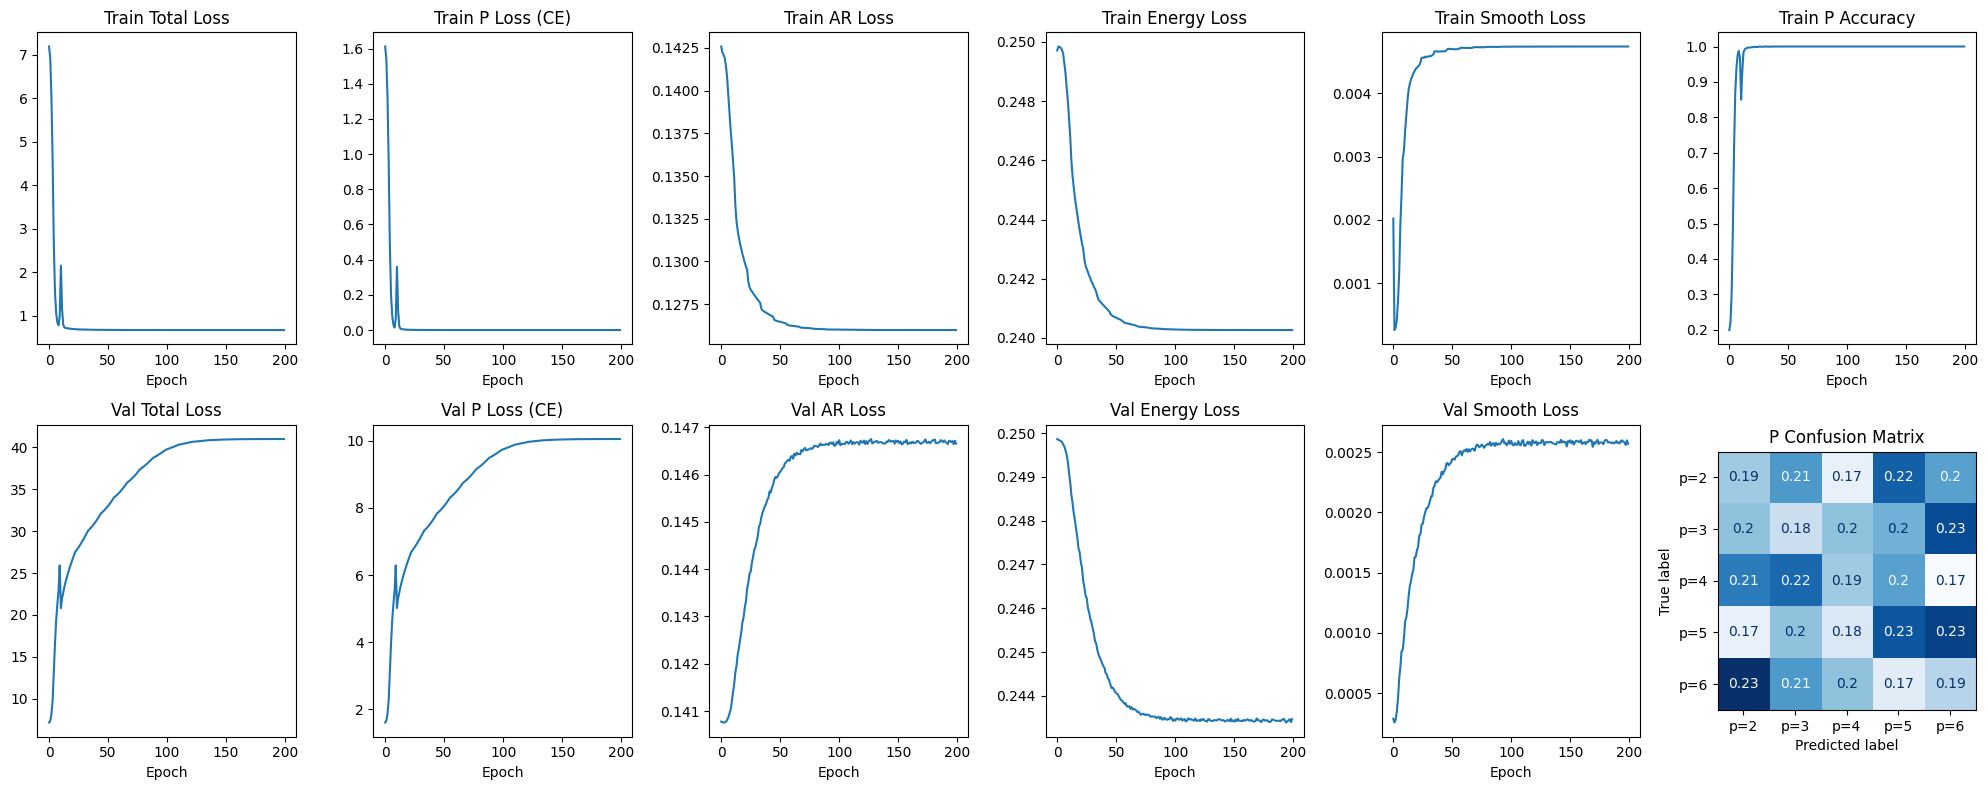

coeff_mse: 0.018762512132525444
signal_mse: 0.14688780903816223
p_mae: 1.6055
p_mape: 0.48181666666666667
p2_acc: 0.185
p3_acc: 0.1925
p4_acc: 0.205
p5_acc: 0.2325
p6_acc: 0.1875
p_acc: 0.2005


In [7]:
model, history = do_bench_on_config(ablation_config["full"])
plot_history(history, model=model, val_loader=val_loader, device=device)
# Slice coef_val to match model output dimension (max_ar_order=6)
full_bench_results = bench_loop(model, X_val, coef_val[:, :, :6], p_val, device)
for k, v in full_bench_results.items():
    print(f"{k}: {v}")

In [8]:
import pandas as pd

ablation_df = pd.DataFrame({
    'full': full_bench_results,
}).T

ablation_df

,coeff_mse,signal_mse,p_mae,p_mape,p2_acc,p3_acc,p4_acc,p5_acc,p6_acc,p_acc
full,0.018763,0.146888,1.6055,0.481817,0.185,0.1925,0.205,0.2325,0.1875,0.2005
